In [1]:
import torch.optim as optim
import torch
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
import random
import os
%run helpers_preproc.ipynb
%run alternate_data.ipynb

In [2]:
origDataDir = 'SHREC11/'
newDataDir = 'SHREC11_plus/'

In [3]:
#generate additional data and update label
origLabel = np.array(readLbl(600,origDataDir + 'labels.txt'),dtype = int) #first take in the original labels
newLabelFile = open(newDataDir + "labels.txt", "w")

In [4]:
radiuss = [0.0002,0.0004,0.0008,0.0016]

for i in range(600):
    #First create the new obj file
    origN = origDataDir + 'T' + str(i) + '.obj'
    
    for j in range(len(radiuss)):
        radius = radiuss[j]
        newN = newDataDir + 'T' + str(i+600*(j)) + '.obj'
    
        #newLabelFile.write("T" + str(i) + ".obj" + " " + str(origLabel[i]) + "\n")
        if not (write_new_files(origN,newN,radius)):
            print('Data generation failed on ' , i)
        
        newLabelFile.write("T" + str(i + 600*(j)) + ".obj" + " " + str(origLabel[i]) + "\n")

    
newLabelFile.close()

In [5]:
#read in the data, get normalized adjacency (NxN)
num_meshes = 600 * 4
train_size = 450 * 4
test_size = 150 * 4
mesh_dir = 'SHREC11_plus/'

In [6]:
num_swaps = 10000

labels = np.array(readLbl(num_meshes,mesh_dir+'labels.txt'))

for swap_idx in range(num_swaps):
    idxA = random.randint(0,num_meshes-1)
    idxB = random.randint(0,num_meshes-1)
    
    if idxA != idxB:
        labelA = labels[idxA]
        labelB = labels[idxB]
        labels[idxA] = labelB
        labels[idxB] = labelA

        #change filenames
        os.rename(mesh_dir+'T' + str(idxA) + '.obj',mesh_dir+'temp.obj')
        os.rename(mesh_dir+'T' + str(idxB) + '.obj',mesh_dir+'T' + str(idxA) + '.obj')
        os.rename(mesh_dir+'temp.obj',mesh_dir+'T' + str(idxB) + '.obj')

newLabelFile = open(newDataDir + "labels.txt", "w")
for i in range(num_meshes):
        newLabelFile.write("T" + str(i) + ".obj" + " " + str(labels[i]) + "\n")


newLabelFile.close()

In [7]:
label_np = np.array(readLbl(num_meshes,mesh_dir+'labels.txt'))

In [8]:
node_sigs_list = []
normed_adjMats_list = []

for i in range(num_meshes):
    fName = 'T' + str(i) + '.obj'
    adj_noscale_read = obj_2_adj_noscale(mesh_dir + fName)
    adj_scaled_read = obj_2_adj(mesh_dir + fName)

    if (adj_scaled_read.shape[0] < 252):
        adj_noscale = np.empty([252,252])
        adj_scaled = np.empty([252,252])
    else:
        adj_noscale = adj_noscale_read
        adj_scaled = adj_scaled_read

    adj_normalized = adj_noscale / np.reshape(np.sum(adj_noscale,axis = 1),[adj_noscale.shape[0],1])

    #node level signal extraction
    node_degs = np.sum(adj_noscale,axis = 0)
    node_neigh_max = np.max(adj_scaled,axis = 0)
    node_neigh_min = np.min(adj_scaled,axis = 0)
    node_neigh_sum = np.sum(adj_scaled,axis = 0)
    node_neigh_mean = np.sum(adj_scaled,axis = 0)

    node_sig = np.stack([node_degs,node_neigh_max,node_neigh_min,node_neigh_sum,node_neigh_mean],axis = 1)
    
    node_sigs_list.append(node_sig)
    normed_adjMats_list.append(adj_normalized)

In [9]:
normed_adjMats = np.nan_to_num(np.stack(normed_adjMats_list))
node_sigs = np.nan_to_num(np.stack(node_sigs_list))

In [10]:
#feature_mean = np.reshape(np.mean(node_sigs,axis = 1),[num_meshes,1,5])
#node_sigs = node_sigs - feature_mean 

In [11]:
node_sigs

array([[[7.        , 0.19927485, 0.        , 0.90142449, 0.90142449],
        [5.        , 0.15861282, 0.        , 0.54160782, 0.54160782],
        [5.        , 0.12691167, 0.        , 0.46070849, 0.46070849],
        ...,
        [4.        , 0.15444274, 0.        , 0.45380854, 0.45380854],
        [7.        , 0.23321221, 0.        , 1.11268998, 1.11268998],
        [4.        , 0.08522359, 0.        , 0.27243597, 0.27243597]],

       [[4.        , 0.13543414, 0.        , 0.42322481, 0.42322481],
        [7.        , 0.17246379, 0.        , 0.98549004, 0.98549004],
        [5.        , 0.16157305, 0.        , 0.68296637, 0.68296637],
        ...,
        [7.        , 0.19070558, 0.        , 1.03827096, 1.03827096],
        [4.        , 0.16756086, 0.        , 0.53211183, 0.53211183],
        [5.        , 0.29521176, 0.        , 0.85702525, 0.85702525]],

       [[6.        , 0.10744272, 0.        , 0.44457877, 0.44457877],
        [5.        , 0.12883174, 0.        , 0.37108488, 0.3

In [12]:
normed_adjMats_tr = normed_adjMats[:train_size,:,:]
node_sigs_tr = node_sigs[:train_size,:,:]
label_np_tr = label_np[:train_size]

normed_adjMats_ts = normed_adjMats[train_size:,:,:]
node_sigs_ts = node_sigs[train_size:,:,:]
label_np_ts = label_np[train_size:]

label_mat_tr = torch.tensor(np.where(igl.all_pairs_distances(label_np_tr,label_np_tr,False) > 0.5,0,1)).float()
label_mat_ts = torch.tensor(np.where(igl.all_pairs_distances(label_np_ts,label_np_ts,False) > 0.5,0,1)).float()

In [13]:
normed_adjMats_tr = torch.tensor(normed_adjMats_tr).float()
node_sigs_tr = torch.tensor(node_sigs_tr).float()
label_tr = torch.tensor(label_np_tr).float()

normed_adjMats_ts = torch.tensor(normed_adjMats_ts).float()
node_sigs_ts = torch.tensor(node_sigs_ts).float()
label_ts = torch.tensor(label_np_ts).float()

In [14]:
#label_mat_train = form_label_matrix(label_mat, train_dict)

In [15]:
#normed_adjMats_list_train, node_sigs_list_train = prep_data(train_dict)

In [16]:
#normed_adjMats_train = np.stack(normed_adjMats_list_train)
#node_sigs_train = np.stack(node_sigs_list_train)

#normed_adjMats_train = torch.tensor(normed_adjMats_train,requires_grad=False).float()
#node_sigs_train = torch.tensor(node_sigs_train,requires_grad=False).float()

#normed_adjMats_train = torch.nan_to_num(normed_adjMats_train,0,0,0)
#node_sigs_train = torch.nan_to_num(node_sigs_train,0,0,0)

In [17]:
node_sigs_tr.shape

torch.Size([1800, 252, 5])

In [18]:
%run NNs.ipynb
g = GCN(5,[5,5,5,5])
n = MLP(252*5,[5,5,5,5])
output1 = g.forward(normed_adjMats_tr,node_sigs_tr)
output2 = n.forward(output1)
print(output1.shape)
print(output2.shape)

torch.Size([1800, 252, 5])
torch.Size([1800, 5])


In [19]:

def lossF(features,lbl_mat):
    disMat = torch.cdist(features,features)
    sameType = disMat * (lbl_mat-torch.diag(torch.ones(lbl_mat.shape[0])))
    diffType = disMat * (1-lbl_mat)

    diffTypeScaled = diffType * torch.exp(-diffType)
    diffTypeScaledMean = torch.sum(diffTypeScaled)/ torch.count_nonzero(diffTypeScaled)
    diffTypeMean = torch.sum(diffType)/ torch.count_nonzero(diffType)

    sameTypeMean = torch.sum(sameType) / torch.count_nonzero(sameType)
    sameTypeStd = torch.sum((sameType - sameTypeMean)**2) / torch.count_nonzero(sameType)

    #toRet = -(sameTypeMean-diffTypeMean)**2 # + 0.01 * torch.sqrt(sameTypeStd)
    #toRet = -(sameTypeMean-diffTypeMean)**2 #+ 0.5*(sameTypeMean + 0.01 * torch.sqrt(sameTypeStd))
    toRet = -(sameTypeMean-diffTypeMean)**2 - diffTypeScaledMean + 0.5 * torch.sqrt(sameTypeStd)
    
    print(sameTypeMean.detach().numpy(),diffTypeMean.detach().numpy(),torch.sqrt(sameTypeStd).detach().numpy(), toRet.detach().numpy())
    return  toRet

In [20]:
optimizer = optim.Adam(g.weights + n.weights,lr = 0.0001)
for i in range(100000):
    optimizer.zero_grad()
    output = n.forward(g.forward(normed_adjMats_tr,node_sigs_tr))
    loss = lossF(output,label_mat_tr)
    loss.backward()
    optimizer.step()

0.040700797 0.04014438 0.23018934 0.07956037
0.035262283 0.034794334 0.2003263 0.0691457
0.037987385 0.03765667 0.21527784 0.07420652
0.040048636 0.03940725 0.2266407 0.078420445
0.038040977 0.03743276 0.21564241 0.07458213
0.038612623 0.038007107 0.21888405 0.07575906
0.038157042 0.037498906 0.21620941 0.074792854
0.038814362 0.038037535 0.2203792 0.076603204
0.033050217 0.032544922 0.18867393 0.06539339
0.035897046 0.035384916 0.20396562 0.07054295
0.03832628 0.037655495 0.21731876 0.07530297
0.03792746 0.037329897 0.21517679 0.074517414
0.03705961 0.03659278 0.21033011 0.07269339
0.035835564 0.035501506 0.20375691 0.07036105
0.036047842 0.035428148 0.2048687 0.07096114
0.03631036 0.035872355 0.20654333 0.071507305
0.03494114 0.034646083 0.19893193 0.068739
0.031182313 0.030818805 0.17848082 0.061822396
0.033261392 0.03280002 0.19019657 0.066049576
0.03192163 0.031352244 0.18241324 0.06329033
0.034977894 0.03469503 0.19911212 0.068783306
0.03442676 0.03394624 0.19642365 0.06822587
0.

0.0016052711 0.0018563098 0.008805654 0.0025514653


KeyboardInterrupt: 

In [21]:
output = n.forward(g.forward(normed_adjMats_tr,node_sigs_tr))
output.shape

torch.Size([1800, 5])

In [22]:
disMat = torch.cdist(output,output).flatten()
mask_same = torch.tensor(label_mat_tr - torch.diag(torch.ones(train_size)),dtype=bool).flatten()
mask_diff = torch.tensor(1 - label_mat_tr,dtype=bool).flatten()
sameComp = disMat[mask_same].detach().numpy()
diffComp = disMat[mask_diff].detach().numpy()
weightsSame = np.ones_like(sameComp) / len(sameComp)
weightsDiff = np.ones_like(diffComp) / len(diffComp)

/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_1517/1331210453.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_same = torch.tensor(label_mat_tr - torch.diag(torch.ones(train_size)),dtype=bool).flatten()
/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_1517/1331210453.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_diff = torch.tensor(1 - label_mat_tr,dtype=bool).flatten()


0.0015862896 0.0018544248


Text(0.5, 1.0, 'Diff Comp')

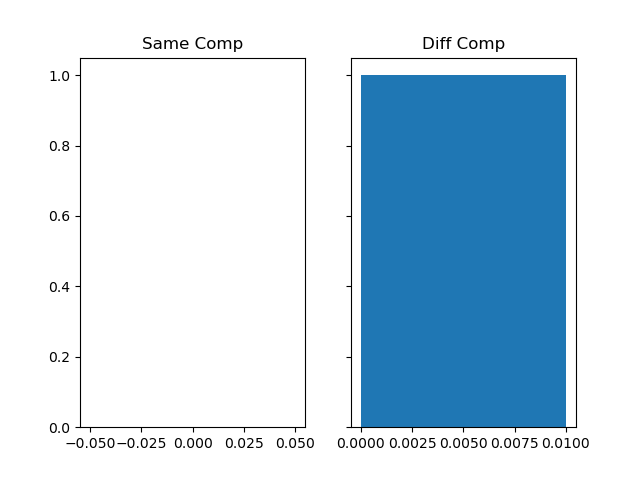

In [23]:
print(np.mean(sameComp),np.mean(diffComp))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(sameComp,bins=np.arange(0,np.max(sameComp),0.01),weights=weightsSame,log = False)
ax1.set_title('Same Comp')
ax2.hist(diffComp,bins=np.arange(0,np.max(diffComp),0.01),weights=weightsDiff,log = False)
ax2.set_title('Diff Comp')

In [24]:
output = n.forward(g.forward(normed_adjMats_ts,node_sigs_ts))
output.shape

torch.Size([600, 5])

In [25]:
disMat = torch.cdist(output,output).flatten()
mask_same = torch.tensor(label_mat_ts - torch.diag(torch.ones(test_size)),dtype=bool).flatten()
mask_diff = torch.tensor(1 - label_mat_ts,dtype=bool).flatten()
sameComp = disMat[mask_same].detach().numpy()
diffComp = disMat[mask_diff].detach().numpy()
weightsSame = np.ones_like(sameComp) / len(sameComp)
weightsDiff = np.ones_like(diffComp) / len(diffComp)

/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_1517/923068292.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_same = torch.tensor(label_mat_ts - torch.diag(torch.ones(test_size)),dtype=bool).flatten()
/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_1517/923068292.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_diff = torch.tensor(1 - label_mat_ts,dtype=bool).flatten()


0.0016717479 0.0019171725


Text(0.5, 1.0, 'Diff Comp')

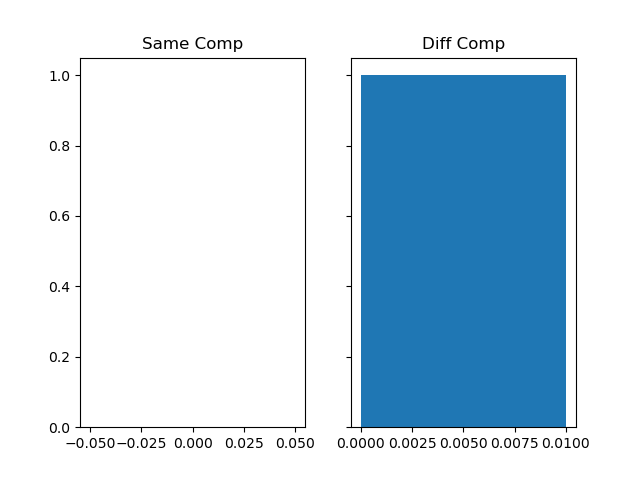

In [26]:
print(np.mean(sameComp),np.mean(diffComp))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(sameComp,bins=np.arange(0,np.max(sameComp),0.01),weights=weightsSame,log = False)
ax1.set_title('Same Comp')
ax2.hist(diffComp,bins=np.arange(0,np.max(diffComp),0.01),weights=weightsDiff,log = False)
ax2.set_title('Diff Comp')

In [27]:
#from matplotlib.pyplot import figure
#figure(figsize=(10, 8), dpi=80)


In [28]:
BigDiffIndices = np.where(disMat.detach().numpy().flatten() > 0.75)[0].tolist()

In [29]:
len(BigDiffIndices)

0

In [30]:
vizMat = np.zeros([30,30])

In [31]:
#Separating 30 categories into less categories

# for index in BigDiffIndices:
#     row, col = divmod(index,test_size)
#     cat1, cat2 = int(label_np_ts[row]),int(label_np_ts[col])
#     if cat1 == cat2:
#         print(cat1, cat2)
#     vizMat[cat1,cat2] += 1
#     vizMat[cat2,cat1] += 1


In [32]:
vizMat = vizMat / np.max(vizMat)

/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_1517/1567513961.py:1: RuntimeWarning: invalid value encountered in divide
  vizMat = vizMat / np.max(vizMat)


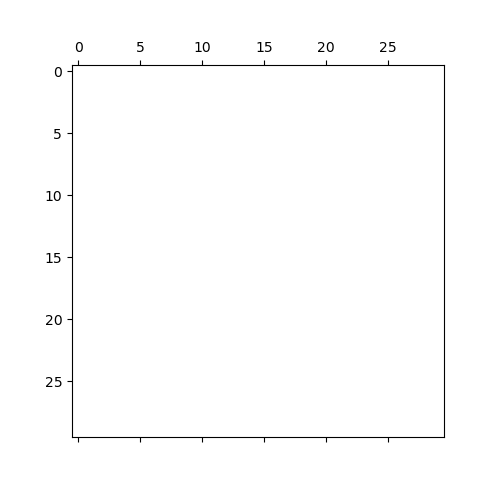

In [33]:
plt.matshow(vizMat)

In [34]:
features = output.detach().numpy()

In [35]:
features.shape

(600, 5)

In [36]:
from sklearn.decomposition import PCA

In [37]:
pca = PCA(n_components=3)
newX = pca.fit_transform(features)
np.sum(pca.explained_variance_ratio_)

0.9877065

In [38]:
newX.shape

(600, 3)

In [39]:
indices_to_show = [0,1,2,3,4]

In [40]:
dataPlot = []
for i in range(len(indices_to_show)):
    a = newX[np.where(label_np_ts == indices_to_show[i]),:]
    a = np.reshape(a,[a.shape[1],a.shape[2]])
    categories = np.ones([a.shape[0],1]) * indices_to_show[i]
    b = np.concatenate((a,categories),axis = 1)
    dataPlot.append(b)
    
dataPlot = np.concatenate(dataPlot,axis = 0)

In [41]:
dataPlot.shape

(113, 4)

In [42]:
plt.clf()

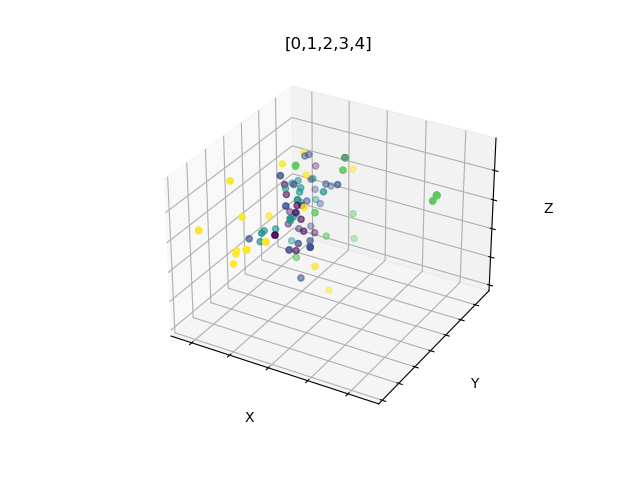

In [43]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(dataPlot[:,0], dataPlot[:,1], dataPlot[:,2], label=dataPlot[:,3], c = dataPlot[:,3], cmap = 'viridis')
#ax.axis('off')
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('[0,1,2,3,4]')

#plt.legend(loc="upper right")

plt.show()